In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from functions import construct_DF，cut_DF, str_to_day, day_to_str, obtain_Features
from plot_Tempo_Spatio import plot_Tempo_Spatio
from ADMM import ADMM
from time import process_time
from STAR import STAR_analysis
from TCP import TCP_analysis

# Data Preparation

Use the county-level dataset of confirmed COVID cases released by New York Times to construct a dataframe in which each row is a time series of **daily new case counts per one million population** (normalized) in each county of **San Francisco Bay Area (SFBA)** within the time window between **Feb 01, 2020 to Apr 21, 2020**. Distance between two counties is measured by the minimum number of times one has to cross the county borders to walk from one county to another.

In [10]:
# Inputs


url = "https://query.data.world/s/7ifvvpyy23sa2fciuvcygehakxlnnv" # URL for raw data

COUNTIES = ["San Francisco", "Alameda",  "Contra Costa", "Marin", "Napa", 
            "San Mateo", "Santa Clara", "Solano", "Sonoma"]
COUNTIES.sort()

STATE = "California"

INFO = pd.read_csv("https://raw.githubusercontent.com/PawinData/UC/SFBA/INFO.csv", 
                   index_col=0)  # population and coordinates of populous center of each county

DistanceMatrix = pd.read_csv("https://raw.githubusercontent.com/PawinData/UC/SFBA/DistanceMatrix_shortestnetworks.csv", 
                             index_col=0)  # shortest-network distance between counties

start = "2020-02-01"  # the time window to investigate
end = "2020-04-21"

In [11]:
# construct dataframe of daily new COVID case counts per 1 million population

DF = construct_DF(url, STATE, COUNTIES, INFO)   # row = time series for a county
DF = cut_DF(DF, start, end)   # only look at a certain time window

## Visualization

In [12]:
import plotly
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

init_notebook_mode(connected=True)

In [20]:
data = list()
COLORS = ["aqua","sienna","coral","darkgreen","darksalmon","darkslateblue","greenyellow","maroon","violet"]

layout = dict(title = "County-level (Normalized) Daily New Cases")

for county, col in zip(COUNTIES,COLORS):
    trace = go.Scatter(x = DF.columns,
                       y = DF.loc[county,:],
                       name = county,
                       line = dict(color = col),
                       opacity = 0.8)
    data.append(trace)
    
fig = dict(data=data, layout=layout)
iplot(fig, filename="Interactive Visualization")

# Verification of Tempo-Spatial Correlation

The difference in the numbers of daily new cases tends to increase in general with the difference in time and distance, which verifies the adoption of the TCP framework. The unusually drastic fluctuation at the right end of the (left) plot for intra-region temporal correlation might suggest errors or outliers in the dataset.

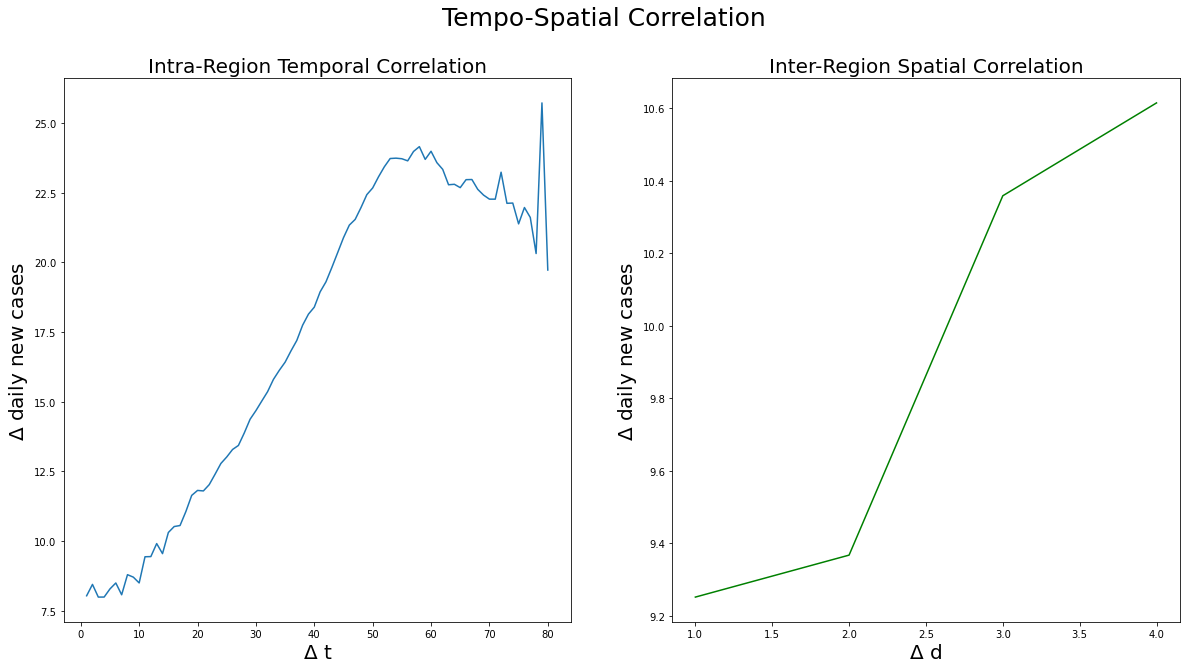

In [21]:
plot_Tempo_Spatio(DF, DistanceMatrix)

# TCP Hyperparameters Tuning

The **ADMM algorithm** generates weights $\mathbf{W}$ from the target matrix $\mathbf{Y}$, the feature matrices $\mathbf{X}$, and the distance matrix $\mathbf{D}$. By fixing the others and optimizing one particular parameter in turn, the arguments for the ADMM algorithm are set to be $(h, \lambda, \rho, \gamma, \epsilon) = (0.5, 4, 0.6, 10^{-3}, 10^{-8})$. It is likely that the contribution of temporal correlation is so strong (i.e $\lambda = 4$) that we may predict new weights for tomorrow from today (i.e lags $= 1$).

In [22]:
Y = DF.copy().to_numpy()     # target matrix

D = DistanceMatrix.copy().to_numpy()    # distance matrix

# feature matrices
X = obtain_Features("Features_normal.p", start, end)   # a sequence of M-by-N feature matrices

# check array shape compatibility
K,M,N = X.shape
if not (Y.shape==(N,K) and D.shape==(N,N)):
    print("Shapes of matrices are not incompatible.")

In [23]:
# initialized model parameters

h = 1          # controls the degree of spatial correlation
lam = 1        # controls the contribution of temporal correlation
rou = 1        # penality in ADMM algorithm
gamma = 0.001  # learning rate in ADMM algorithm
eps = 10**(-8) # significance level
lags = 7       # the number of days to look back


## Penalty in ADMM optimization: $\rho$

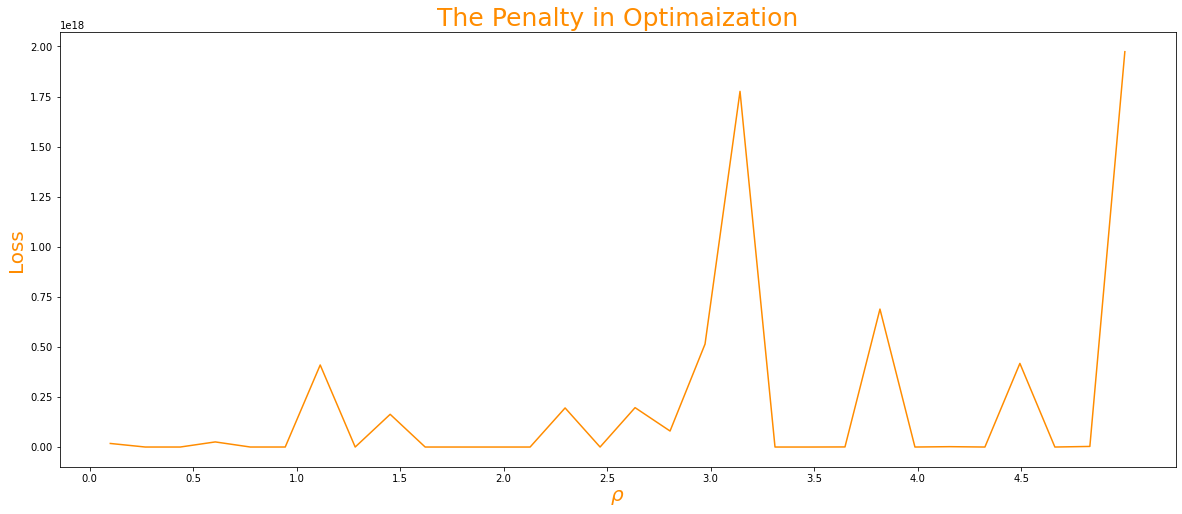

In [22]:
pnlty = np.linspace(0.1, 5, 30)

plt.figure(figsize=(20,8))
plt.plot(pnlty, [ADMM(X,Y,D,h,lam, val).Loss for val in pnlty], color="darkorange")
plt.xticks(np.arange(0, 5, step=0.5))
plt.title("The Penalty in Optimaization", color="darkorange", fontsize=25)
plt.xlabel(r"$\rho$", color="darkorange", fontsize=20)
plt.ylabel("Loss", color="darkorange", fontsize=20)
plt.show()


## Inter-region spatial correlation: $h$

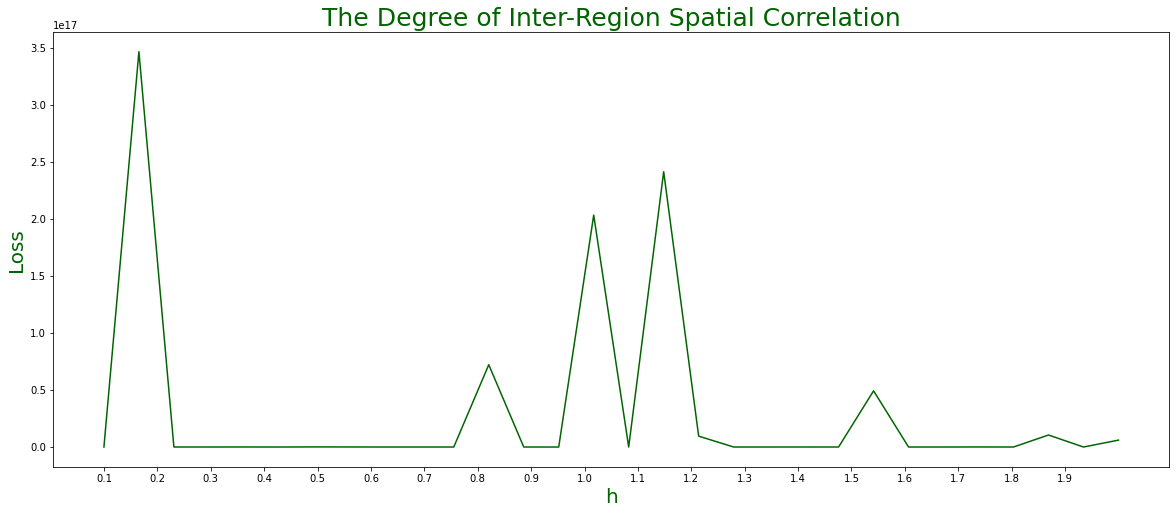

In [32]:
h_vec = np.linspace(0.1, 2, 30)

plt.figure(figsize=(20,8))
plt.plot(h_vec, [ADMM(X,Y,D, val, lam,rou=0.6).Loss for val in h_vec], color="darkgreen")
plt.xticks(np.arange(0.1,2, step=0.1))
plt.title("The Degree of Inter-Region Spatial Correlation", color="darkgreen", fontsize=25)
plt.xlabel("h", color="darkgreen", fontsize=20)
plt.ylabel("Loss", color="darkgreen", fontsize=20)
plt.show()

## Intra-region temporal correlation: $\lambda$


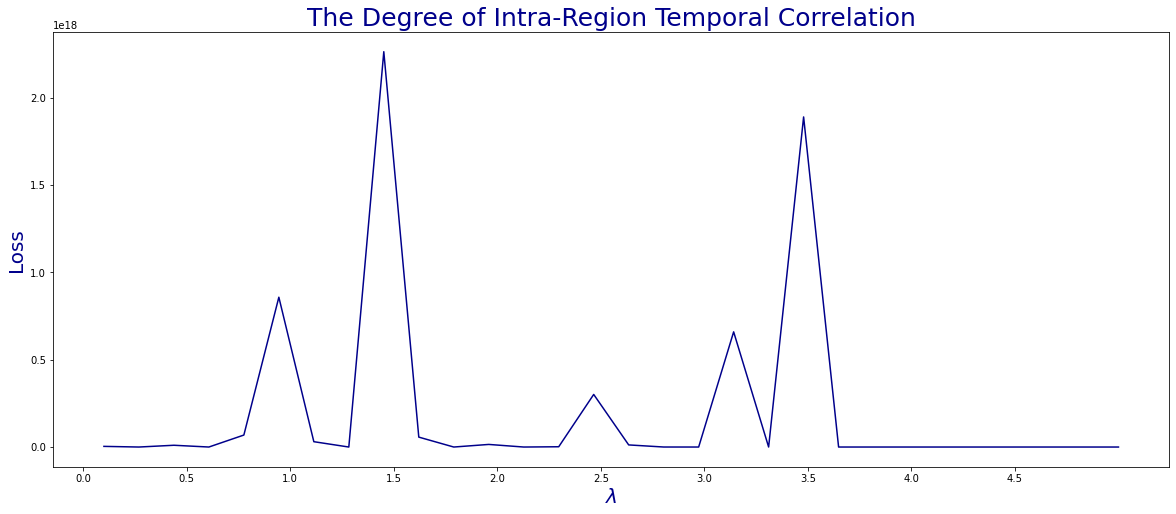

In [43]:
lb = np.linspace(0.1, 5, 30)

plt.figure(figsize=(20,8))
plt.plot(lb, [ADMM(X,Y,D,0.5, val, rou=0.6).Loss for val in lb], color="darkblue")
plt.xticks(np.arange(0, 5, step=0.5))
plt.title("The Degree of Intra-Region Temporal Correlation", color="darkblue", fontsize=25)
plt.xlabel("$\lambda$", color="darkblue", fontsize=20)
plt.ylabel("Loss", color="darkblue", fontsize=20)
plt.show()

## Time lags

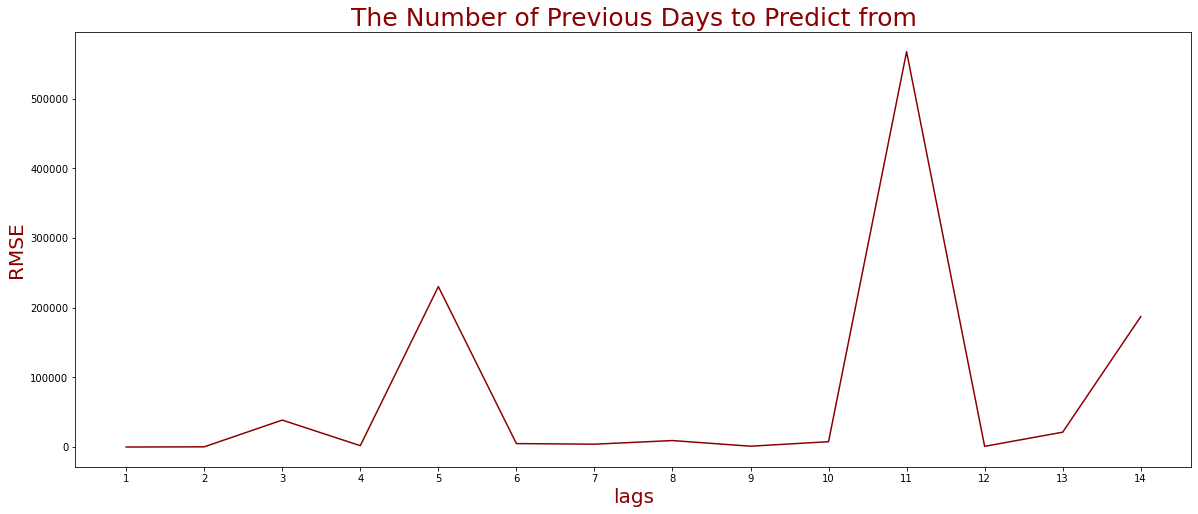

In [48]:
lags_vec = [j for j in range(1,14+1)]

plt.figure(figsize=(20,8))
plt.plot(lags_vec, [TCP_analysis(X,Y,D,0.5,4, val, 0.6, gamma,eps) for val in lags_vec], color="darkred")
plt.xticks(np.arange(1,15, step=1))
plt.title("The Number of Previous Days to Predict from", color="darkred", fontsize=25)
plt.xlabel("lags", color="darkred", fontsize=20)
plt.ylabel("RMSE", color="darkred", fontsize=20)
plt.show()

# Performance Analysis: TCP vs STAR

Make predictions for **the last five days** in the dataset and compare the performance, by root mean square error (**RMSE**), as well as **computing time** using the **TCP Framework** to that using the baseline, **Space-Time Auto-Regression (STAR)** model. Note that the process of fitting $\mathbf{Y}$ and $\mathbf{D}$ to STAR diverges for every $T < 14$, implying that features $\mathbf{X}$ and weights $\mathbf{W}$ reflects heavier temporal correlation than normalized case counts $\mathbf{Y}$ do, and thus STAR requires more days of retrospection for building up the model.

In [24]:
# TCP
h = 0.5          # controls the degree of spatial correlation
lam = 4          # controls the contribution of temporal correlation
rou = 0.6        # penality in ADMM algorithm
gamma = 0.001    # learning rate in ADMM algorithm
eps = 10**(-8)   # significance level
lags = 1         # the number of days to regress upon for generating new weights in TCP

# STAR (baseline)
T = 14           # the number of days to look back

In [28]:
sample_size = 5

results = list()

for j in reversed(range(sample_size)):
    time_TCP = process_time()    # compute for TCP
    RMSE_TCP = TCP_analysis(X[:(K-j),:,:], Y[:,:(K-j)], D, h, lam, lags, rou, gamma, eps)
    RMSE_TCP = round(RMSE_TCP, 4)
    time_TCP = round(process_time() - time_TCP, 2)
    
    time_STAR = process_time()   # compute for STAR (baseline)
    RMSE_STAR = round(STAR_analysis(Y[:,:(K-j)], D, T, h), 4)
    time_STAR = round(process_time() - time_STAR, 2)
    
    results.append([DF.columns[-j-1], RMSE_TCP, RMSE_STAR, time_TCP, time_STAR])   # a row of the final table

    
results = pd.DataFrame(np.array(results), 
                       index=["Run "+str(j+1) for j in range(sample_size)], 
                       columns=["Date predicted", "RMSE TCP","RMSE STAR", "Time TCP", "Time STAR"])

results

,Date predicted,RMSE TCP,RMSE STAR,Time TCP,Time STAR
Run 1,2020-04-17,23.9561,97.323,3188.08,2.62
Run 2,2020-04-18,23.807,59.2504,3228.0,2.62
Run 3,2020-04-19,844.3095,101.1699,3252.25,2.69
Run 4,2020-04-20,56.4458,90.7416,3.34,2.91
Run 5,2020-04-21,23.4244,66.7238,3.66,2.72


**Our findings:**
1. TCP remarkably outperforms STAR in four out of five runs, in that RMSEs at least double for the latter.
2. STAR holds higher robustness in general while both RMSEs and computing time of TCP fluctuate dramatically. A single run of predicting by TCP could take nearly one hour in some case, which is definitely infeasible.
3. Both TCP and STAR behave peculiarly when predicting for April 19, 2020 (i.e in Run 3), in which day a suspiciously large number of zeros appeared in $\mathbf{Y}$. In particular, the normalized new case count in San Mateo skyrocketed the next day to such an extent that it raised outlier alert *(see below)*. Because April 19, 2020 was a Sunday, we suspect that tests and reports in multiple counties happened to be delayed to Monday and caused noticeable singularity. In addition, the turning point of the pandemic occurred in mid-April to late April for SFBA, making modeling the trending extra susceptible to errors.
4. The temporal correlation among features $\mathbf{X}$ and weights $\mathbf{W}$ is much stronger than that among $\mathbf{Y}$.
5. TCP is highly sensitive to a great number of hyperparameters and requires careful, ad-hoc tuning.

In [76]:
# the last 5 columns of Y
DF[[day_to_str(day) for day in range(str_to_day("2020-04-17"), 1+str_to_day(end))]]

,2020-04-17,2020-04-18,2020-04-19,2020-04-20,2020-04-21
Alameda,8.974894,30.514638,29.916312,16.154809,28.719660
Contra Costa,14.737422,32.075567,6.935258,12.136701,36.410103
Marin,0.000000,7.923648,23.770943,15.847295,3.961824
Napa,36.634331,14.653732,0.000000,14.653732,36.634331
San Francisco,44.240309,89.614985,22.687338,66.927647,17.015503
San Mateo,39.135216,53.484795,0.000000,106.969591,19.567608
Santa Clara,19.192345,0.000000,0.000000,26.973025,12.449088
Solano,31.450801,0.000000,0.000000,26.612216,2.419292
Sonoma,16.533093,0.000000,2.066637,2.066637,20.666366


In [29]:
results.to_csv("TCP_STAR.csv")

results.to_latex()

'\\begin{tabular}{llllll}\n\\toprule\n{} & Date predicted &  RMSE TCP & RMSE STAR & Time TCP & Time STAR \\\\\n\\midrule\nRun 1 &     2020-04-17 &   23.9561 &    97.323 &  3188.08 &      2.62 \\\\\nRun 2 &     2020-04-18 &    23.807 &   59.2504 &   3228.0 &      2.62 \\\\\nRun 3 &     2020-04-19 &  844.3095 &  101.1699 &  3252.25 &      2.69 \\\\\nRun 4 &     2020-04-20 &   56.4458 &   90.7416 &     3.34 &      2.91 \\\\\nRun 5 &     2020-04-21 &   23.4244 &   66.7238 &     3.66 &      2.72 \\\\\n\\bottomrule\n\\end{tabular}\n'